In [1]:
# Step 0. Load libraries and custom functions
# Dataframes, vectors & matrices
import pandas as pd
import numpy as np
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Statistics
import scipy.stats as scp_stats
import statsmodels.api as sm
# Time series
import darts

In [2]:
# Step 1. Load dataset
# 1.1 Read csv and get basic info
df_raw = pd.read_csv('../data/ventas_final.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10879 entries, 0 to 10878
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha_Formato     10879 non-null  object 
 1   Fecha             10879 non-null  object 
 2   Codigo            10879 non-null  int64  
 3   Descripcion       10879 non-null  object 
 4   Precio_Unitario   10879 non-null  float64
 5   Costo_Unitario    10879 non-null  float64
 6   Cantidad_Vendida  10879 non-null  float64
 7   Ganancia          10879 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 680.1+ KB


In [3]:
df_raw.sample(5, random_state=2024)

,Fecha_Formato,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
10849,2024-02-05,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,1.10
3320,2023-01-30,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,26.10
1150,2022-10-17,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,0.50
7147,2022-10-24,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,7.84
6449,2023-06-19,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,51.95


In [4]:
df_interim = df_raw.copy()
df_interim = df_interim.set_index(['Fecha_Formato'])
df_interim['Codigo'] = df_interim['Codigo'].astype(str)
df_interim.sample(5, random_state=2024)

,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
Fecha_Formato,,,,,,,
2024-02-05,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,1.10
2023-01-30,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,26.10
2022-10-17,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,0.50
2022-10-24,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,7.84
2023-06-19,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,51.95


In [5]:
df = df_interim.copy()

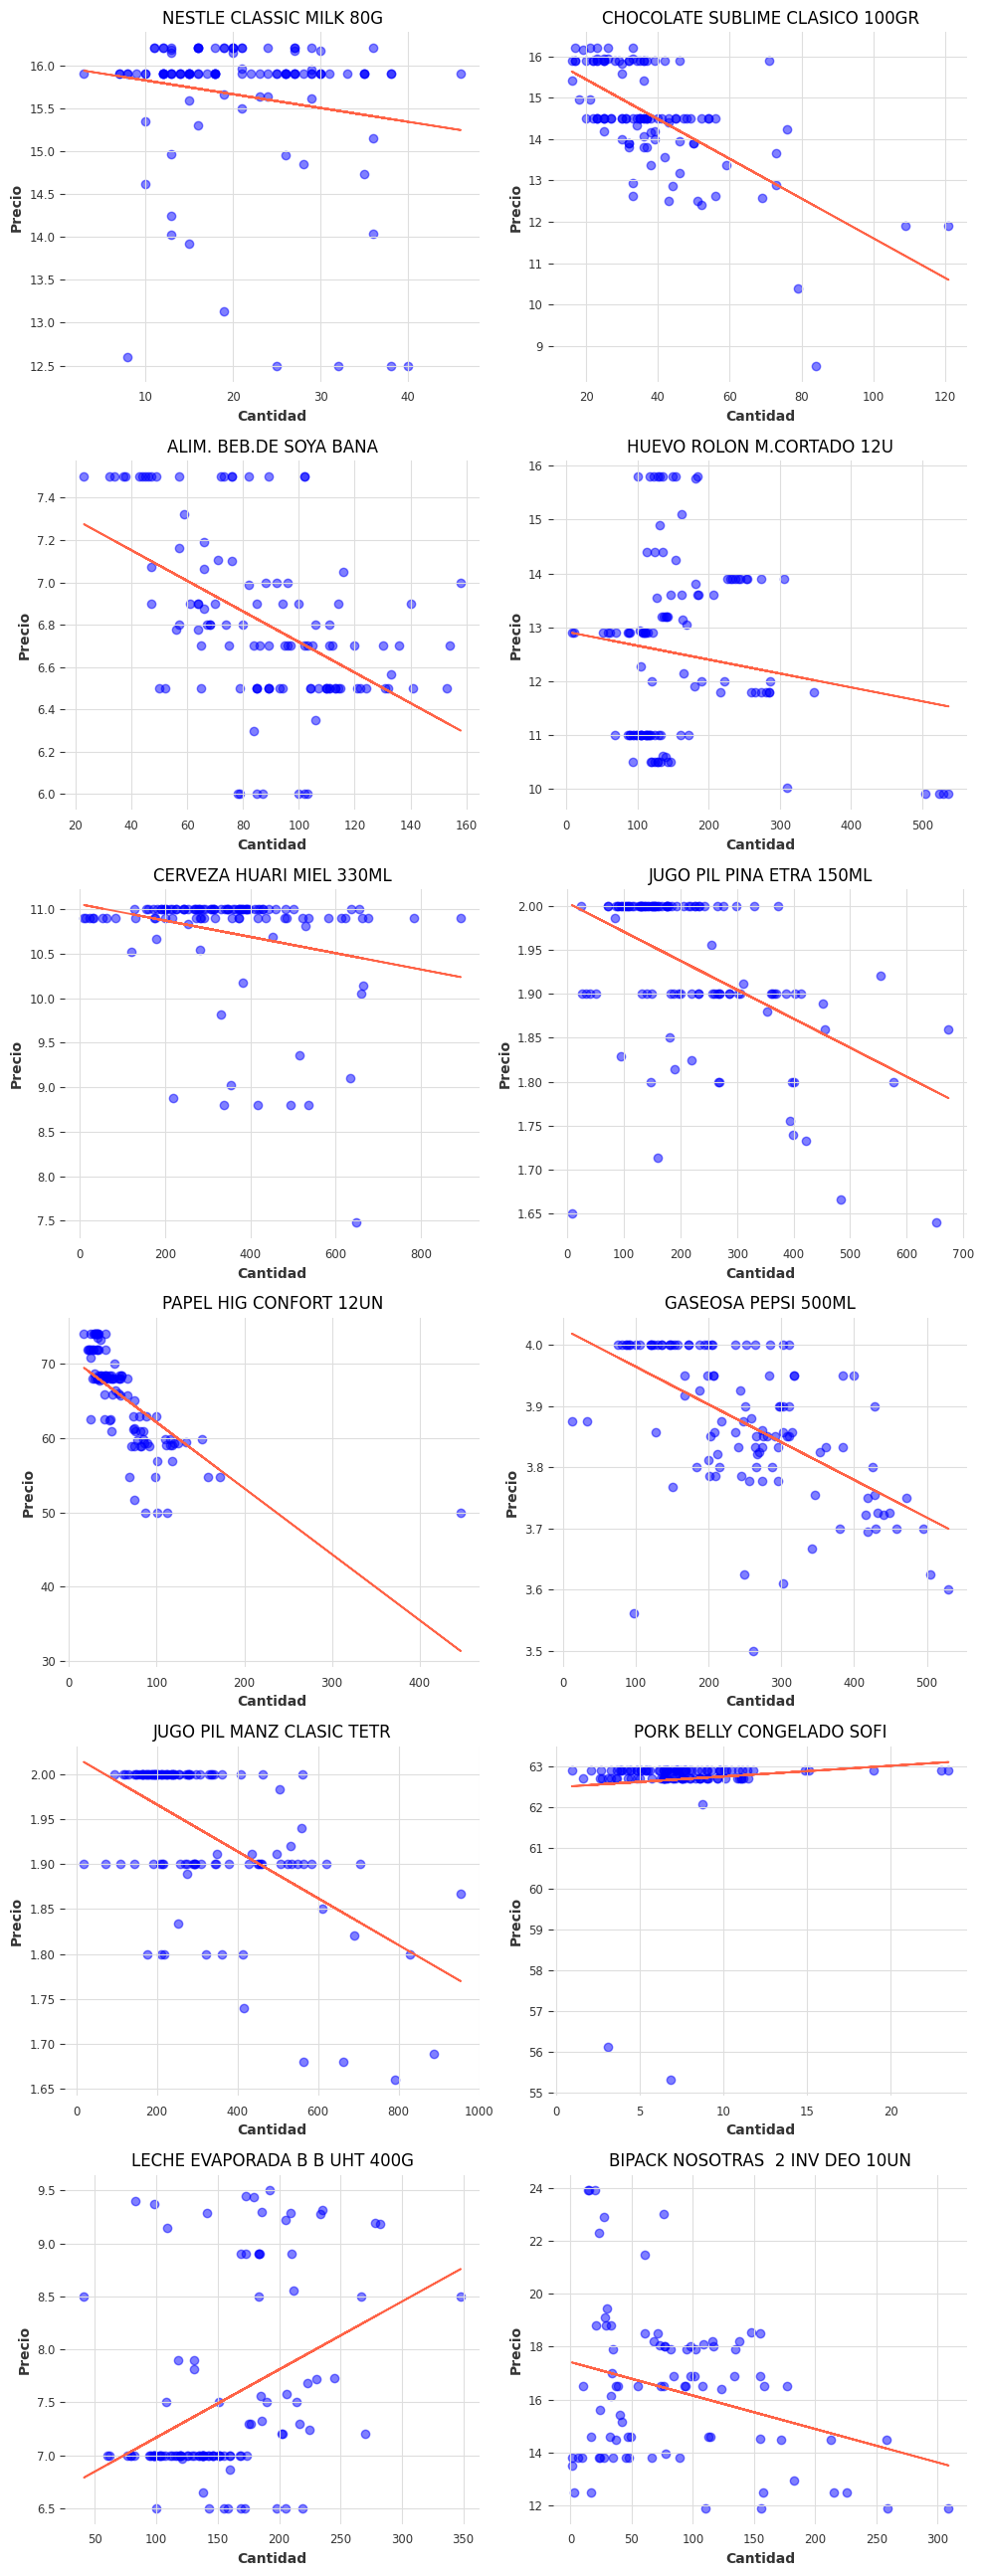

In [28]:
categories = df['Descripcion'].unique().tolist()
fig, axs = plt.subplots(6,2,figsize=(10,26))
for i, ax in enumerate(axs.flatten()):
    temp_df = df[df['Descripcion']==categories[i]].\
        reset_index().groupby(['Fecha_Formato']).\
            agg({'Cantidad_Vendida':'sum', 'Precio_Unitario':'mean'})
    z = np.polyfit(temp_df['Cantidad_Vendida'],temp_df['Precio_Unitario'],1)
    p = np.poly1d(z)
    ax.scatter(temp_df['Cantidad_Vendida'],
               temp_df['Precio_Unitario'], 
               c='b', alpha=0.5)
    ax.plot(temp_df['Cantidad_Vendida'],p(temp_df['Cantidad_Vendida']), c='Tomato')
    ax.set_title(categories[i])
    ax.set_xlabel('Cantidad')
    ax.set_ylabel('Precio')
plt.tight_layout()
plt.show()

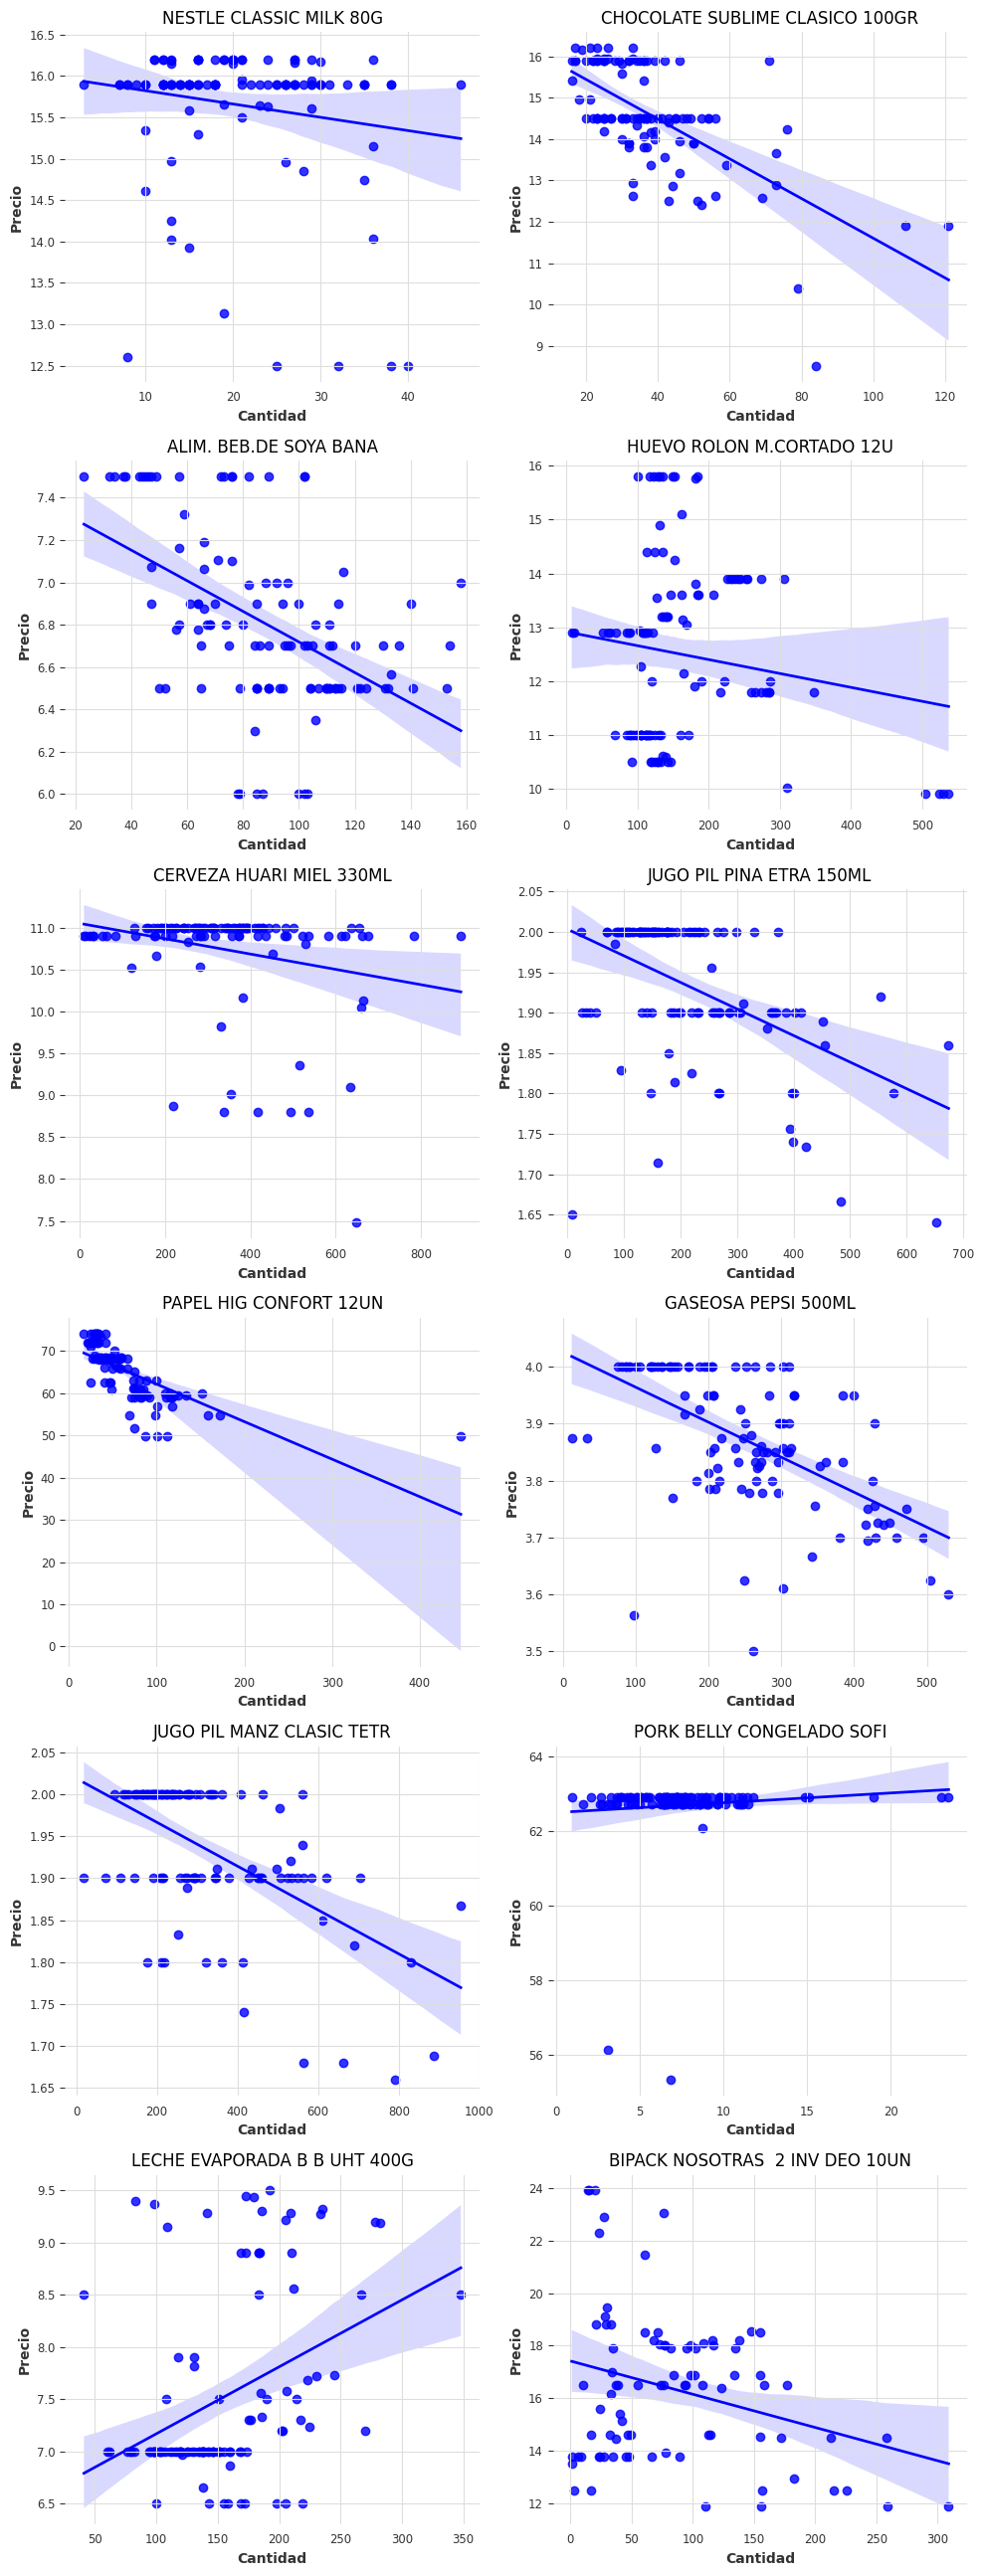

In [30]:
import seaborn as sns
categories = df['Descripcion'].unique().tolist()
fig, axs = plt.subplots(6,2,figsize=(10,26))
for i, ax in enumerate(axs.flatten()):
    temp_df = df[df['Descripcion']==categories[i]].\
        reset_index().groupby(['Fecha_Formato']).\
            agg({'Cantidad_Vendida':'sum', 'Precio_Unitario':'mean'})
    sns.regplot(x='Cantidad_Vendida', y='Precio_Unitario', data=temp_df, ax=ax, color='b')
    ax.set_title(categories[i])
    ax.set_xlabel('Cantidad')
    ax.set_ylabel('Precio')
plt.tight_layout()
plt.show()